# QKeras RNN comparison


1. Create a model and compare its performance to the boosted model
2. If the model outreach the performance of the boosted model : 
 -   create a model with the same feature with qkeras (QAT) and 
 -   quantized the keras model (PTQ)
3. Compare those two to PTQ boosted model

The models with keras should converge to around 1e-5 or 9.8e-6

For QKeras it's been somewhere around 1.1e-5 or so



# To Run Everytime

## Imports

In [1]:
import tensorflow as tf
import keras
import numpy as np
import time
import random
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, LSTM, GRU, SimpleRNN, Conv2D, MaxPooling2D, Flatten, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2, l1, l1_l2
from collections import deque

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

import qkeras
from qkeras import *

import hls4ml
import pickle


2022-06-27 11:20:46.316873: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-27 11:20:46.316908: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


name convert optimizers ['fuse_bias_add', 'remove_useless_transpose', 'output_rounding_saturation_mode', 'qkeras_factorize_alpha', 'extract_ternary_threshold', 'fuse_consecutive_batch_normalization'] File: flow.py Line: 23
name optimize optimizers ['eliminate_linear_activation', 'fuse_consecutive_batch_normalization', 'fuse_batch_normalization', 'replace_multidimensional_dense_with_conv'] File: flow.py Line: 23
vivado:merge_batch_norm_quantized_tanh Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:quantize_dense_output Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:batchnormalizationquantizedtanh_config_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:batchnormalizationquantizedtanh_function_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:clone_output Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:clone_function_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:optimize_pointwise_conv Get_Optimizer, optimizer/opti

/atlas/bonnet/hls4ml/hls4ml/hls4ml/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [2]:
# Load libraries if they are changed
%load_ext autoreload
%autoreload 2


## Data creation 

In [3]:
from nnlar.datashaper import DataShaper
ds = DataShaper.from_h5("../../data/rdgap_mu140.h5")

x, x_val, x_test, y, y_val, y_test = ds()

shapes (1999995, 5, 1) (1999995, 1)
shapes (899992, 5, 1) (99995, 5, 1) (999998, 5, 1)


In [4]:
boosted_model =  tf.keras.models.load_model('../../pb_file')

boosted_model.summary()


2022-06-27 11:20:55.317721: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-27 11:20:55.317768: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-27 11:20:55.317802: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (marbeauty.in2p3.fr): /proc/driver/nvidia/version does not exist
2022-06-27 11:20:55.318246: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


## Settings

In [5]:
# settings of the networks 
output = 1

nbr_batch = 64
nbr_epoch = 200
lr=0.001
lr1=0.001

time_step = 5
nbr_conv_epoch = 70 #number of epochs for the conversion 

weight_decay=0.00000001
patience_es = 12
patience_es1 = 7
patience_rlr = 3
patience_rlr1 = 5
delta = 0.00000001
regularizer = l2

def version(v): return (v)
versions_range = 4 

def units(j): return (j+8)
units_range = 1

In [6]:
integer = 0
integer_1 = -1
def bit_lenghts(i):
    #To change to create models with different bits parameter by defining the smallest bit lenghts 
    #Example : bits 8 ==> (i+4)*4
    return (i+3)*2

def bit_width(i): return {'bits': (i+3)*2, 'integer': integer, 'symmetric': 0, 'alpha':1}

rest_array = [8,10,12]
rest_units_range =  3
bits_range = 5

In [7]:
# path

#path of the tested models 
def models_path(v) : return f"tests/models/optimized_model.h5" 
def predicts_path(v) : return f"tests/predicts/optimized_model.npy" 

#path of the qconverted models
def qmodels_path(i,v,k): return f"tests/qmodels/qmodels_conv_lr={lr1}_patiencES={patience_es1}_patienceRLR={patience_rlr1}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest={rest_array[k]}_v{version(v)}.h5"
def qpredicts_path(i, v, k): return f"tests/qpredicts/qmodels_conv_lr={lr1}_patiencES={patience_es1}_patienceRLR={patience_rlr1}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest={rest_array[k]}_v{version(v)}.npy"
def qpredicts_path_240(i, v, k): return f"tests/qpredicts_240/qmodels_conv_lr={lr1}_patiencES={patience_es1}_patienceRLR={patience_rlr1}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest={rest_array[k]}_v{version(v)}.npy"

def qmodels_path1(i,v,k): return f"tests/qmodels/qmodels_conv_lr={lr1}_patiencES={patience_es1}_patienceRLR={patience_rlr1}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer_1}>_rest={rest_array[k]}_v{version(v)}.h5"
def qpredicts_path1(i, v, k): return f"tests/qpredicts/qmodels_conv_lr={lr1}_patiencES={patience_es1}_patienceRLR={patience_rlr1}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer_1}>_rest={rest_array[k]}_v{version(v)}.npy"
def qpredicts_path_240_1(i, v, k): return f"tests/qpredicts_240/qmodels_conv_lr={lr1}_patiencES={patience_es1}_patienceRLR={patience_rlr1}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer_1}>_rest={rest_array[k]}_v{version(v)}.npy"

def qmodels_path2(i): return f"tests/qmodels/qmodels_conv_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest=12.h5"
def qpredicts_path2(i): return f"tests/qpredicts/qmodels_conv_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest=12.npy"


#path of the qtrained models
def qtrained_models_path(j, i): return f"tests/qmodels_test/qtrained/qmodels_units={units(j)}_epoch={nbr_epoch}_batch={nbr_batch}_lr={lr},<{bit_lenghts(i)},{integer}>.h5"
def qtrained_predicts_path(j, i):  return f"tests/qpredicts_test/qtrained/qmodels_units={units(j)}_epoch={nbr_epoch}_batch={nbr_batch}_lr={lr},<{bit_lenghts(i)},{integer}>.npy"

#path of the qref models 
def qrefmodels_path (i) : return f"qmodels_epoch={nbr_conv_epoch}/qmodels<{bit_lenghts(i)},{integer}>.h5"
def qrefpredicts_path (i) : return f"qpredicts_epoch={nbr_conv_epoch}/qpredicts<{bit_lenghts(i)},{integer}>.npy"

# 3. Compare the results

In [8]:
def exist(path,modeltopred):
    if (os.path.exists(path)==False):
        np.save(path, modeltopred.predict(x_test))
     
    else : print(f'{path} already exists')
def exist_std(path,modeltopred):
    cut_indices = np.where(y_test > 0.24/16)[0]
    if (os.path.exists(path)==False):
        np.save(path, modeltopred.predict(x_test[cut_indices]))
     
    else : print(f'{path} already exists')

## Predictions

In [9]:
model = tf.keras.models.load_model(models_path(0))      
exist(predicts_path(0), model)
ref = 'tests/ref_predicts.npy'
exist(ref, boosted_model)
std_ref = 'tests/std_ref_predicts.npy'
exist_std(std_ref, boosted_model)

for i in range(2,bits_range):
    for v in range (4):
        k=1

        """qmodel0 = qkeras.utils.load_qmodel(qmodels_path(i,v,k))        
        exist(qpredicts_path(i,v,k), qmodel0)
        qmodel0 = qkeras.utils.load_qmodel(qmodels_path(i,v,k))        
        exist_std(qpredicts_path_240(i,v,k), qmodel0)"""
        qmodel1 = qkeras.utils.load_qmodel(qmodels_path1(i,v,k))        
        exist(qpredicts_path1(i,v,k), qmodel1)
        qmodel1 = qkeras.utils.load_qmodel(qmodels_path1(i,v,k))        
        exist_std(qpredicts_path_240_1(i,v,k), qmodel1)    
        
        

        """
        qmodel1 = qkeras.utils.load_qmodel(qmodels_path1(i))        
        exist(qpredicts_path1(i), qmodel1)


        qmodel2 = qkeras.utils.load_qmodel(qmodels_path2(i))        
        exist(qpredicts_path2(i), qmodel2)
        qmodel3 = qkeras.utils.load_qmodel(qmodels_path3(i))        
        exist(qpredicts_path3(i), qmodel3)"""





tests/predicts/optimized_model.npy already exists
tests/ref_predicts.npy already exists
tests/std_ref_predicts.npy already exists
tests/qpredicts/qmodels_conv_lr=0.001_patiencES=7_patienceRLR=5_mindelta1e-08,rkernel<10,-1>_rest=10_v0.npy already exists
tests/qpredicts_240/qmodels_conv_lr=0.001_patiencES=7_patienceRLR=5_mindelta1e-08,rkernel<10,-1>_rest=10_v0.npy already exists
tests/qpredicts/qmodels_conv_lr=0.001_patiencES=7_patienceRLR=5_mindelta1e-08,rkernel<10,-1>_rest=10_v1.npy already exists
tests/qpredicts_240/qmodels_conv_lr=0.001_patiencES=7_patienceRLR=5_mindelta1e-08,rkernel<10,-1>_rest=10_v1.npy already exists
tests/qpredicts/qmodels_conv_lr=0.001_patiencES=7_patienceRLR=5_mindelta1e-08,rkernel<10,-1>_rest=10_v2.npy already exists
tests/qpredicts_240/qmodels_conv_lr=0.001_patiencES=7_patienceRLR=5_mindelta1e-08,rkernel<10,-1>_rest=10_v2.npy already exists
tests/qpredicts/qmodels_conv_lr=0.001_patiencES=7_patienceRLR=5_mindelta1e-08,rkernel<10,-1>_rest=10_v3.npy already exis

## Plotting

bits= 6
1.1335331e-05
1.0728114e-05
1.0735571e-05
1.0234435e-05
bits= 8
1.03995135e-05
1.0379323e-05
1.0599941e-05
1.05436375e-05
bits= 10
1.0708209e-05
1.019841e-05
1.06106045e-05
1.0653881e-05
bits= 12
1.04314195e-05
1.0443874e-05
1.0461329e-05
1.07706655e-05
bits= 14
1.0210302e-05
1.0023862e-05
1.0840796e-05
1.1767599e-05


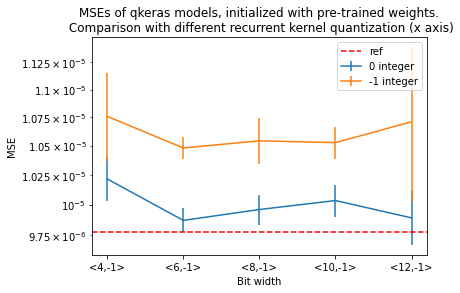

In [10]:
k=1
error=[]
loss=[]
bits=[]
x=[]
error=[]
loss=[]


for i in range( bits_range):
    x.append(i)
    bits.append(bit_lenghts(i)-2)
    best_mse=100
    worst_mse=00
    tmp_loss=[]
    sum = 0
    for v in range (4):
        y_keras0 = np.load(qpredicts_path(i,v,k))
        tmp_mse = mse(y_test,y_keras0)
        sum = sum+tmp_mse

        tmp_loss.append(tmp_mse)
        if (best_mse>tmp_mse): best_mse=tmp_mse
        if (worst_mse<tmp_mse): worst_mse=tmp_mse      
    loss.append(sum/4)
    error.append(np.std(tmp_loss))

plt.errorbar(x=x,y=loss, yerr=error)
error=[]
loss=[]


for i in range(bits_range):
    best_mse=100
    worst_mse=00
    tmp_loss=[]
    sum = 0
    print("bits=",bit_lenghts(i))
    for v in range (4):
        y_keras0 = np.load(qpredicts_path1(i,v,k))
        tmp_mse = mse(y_test,y_keras0)

        print(tmp_mse)
        sum = sum+tmp_mse
        tmp_loss.append(tmp_mse)
        if (best_mse>tmp_mse): best_mse=tmp_mse
        if (worst_mse<tmp_mse): worst_mse=tmp_mse      
    loss.append(sum/4)
    error.append(np.std(tmp_loss))

plt.errorbar(x=x,y=loss, yerr=error)




#plt.axhline(MSETIENNE, linestyle="-", color = 'blue')
plt.axhline(mse(y_test, np.load(ref)), linestyle="--", color = 'red')

plt.legend(['ref','0 integer','-1 integer'])
plt.title(f'MSEs of qkeras models, initialized with pre-trained weights.\n Comparison with different recurrent kernel quantization (x axis)')
plt.ylabel("MSE")
plt.xlabel("Bit width")   
plt.xticks(np.arange(len(bits)), [f"<{Bit},{0 or -1}>" for Bit in bits])
plt.yscale('log')
plt.show()

In [11]:
print (np.load(qpredicts_path1(2,2,1)))

[[0.00108054]
 [0.        ]
 [0.        ]
 ...
 [0.00183938]
 [0.00031258]
 [0.        ]]


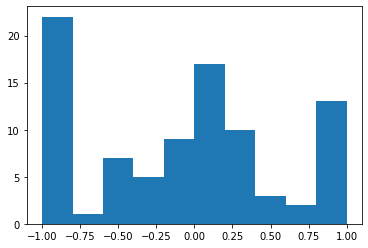

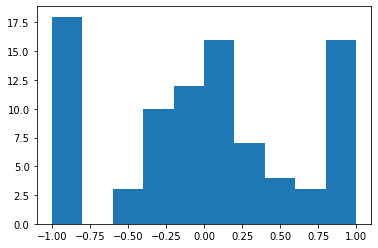

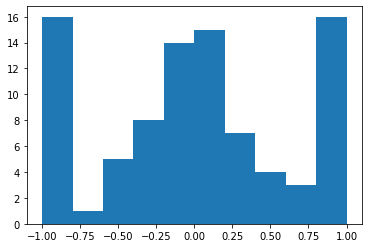

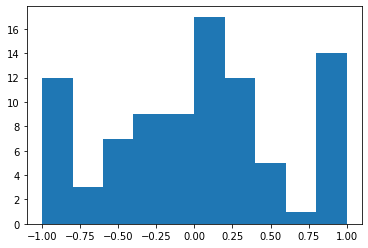

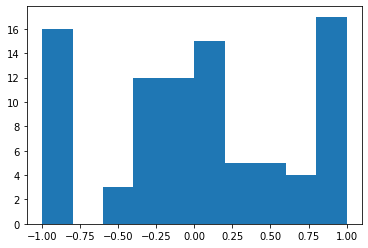

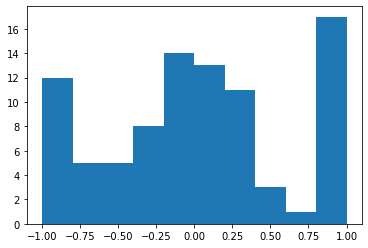

In [12]:
for i in range(2,bits_range):
    for v in range (2,4):
        k=1
        qmodel1 = qkeras.utils.load_qmodel(qmodels_path1(i,v,k))        
        plt.hist(np.concatenate([i.flatten() for i in qmodel1.get_weights()]))
        plt.show()

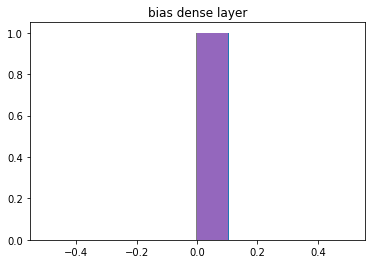

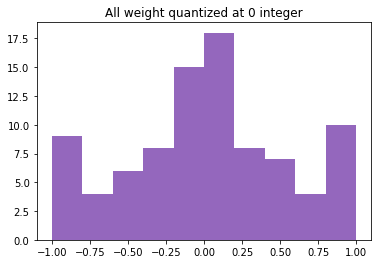

In [13]:
for i in range(bits_range):
    for v in range (1,4):
        k=1
        qmodel1 = qkeras.utils.load_qmodel(qmodels_path(i,v,k))        
        plt.hist(np.concatenate([i.flatten() for i in qmodel1.layers[1].get_weights()[1]]))
        plt.title("bias dense layer")
plt.show()
for i in range(bits_range):
    for v in range (1,4):
        k=1
        plt.hist(np.concatenate([i.flatten() for i in qmodel1.get_weights()]))
        plt.title("All weight quantized at 0 integer")
plt.show()
        

In [14]:
print(qkeras.utils.load_qmodel(qmodels_path1(2,1,1)).layers[0].recurrent_quantizer)
print(qkeras.utils.load_qmodel(qmodels_path1(2,1,1)).layers[0].get_quantizers()[0])



{'class_name': 'quantized_bits', 'config': DictWrapper({'bits': 10, 'integer': -1, 'symmetric': 0, 'alpha': 1, 'keep_negative': True, 'use_stochastic_rounding': False, 'qnoise_factor': 1.0})}
quantized_bits(10,-1,0,alpha=1)


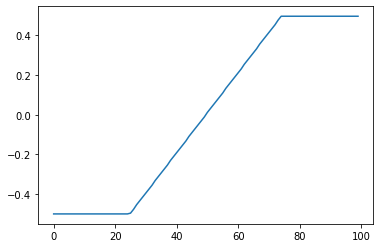

In [15]:
plt.plot(qkeras.quantized_bits(bits=8, integer=-1, alpha =1.0)(np.linspace(-1, 1,100)))


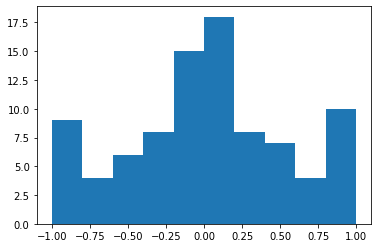

In [16]:
plt.show(plt.hist(np.concatenate([i.flatten() for i in qmodel1.get_weights()])))

[ 9.91191387e-01  9.92121279e-01  9.93502200e-01 -9.86663163e-01
 -9.78282511e-01  3.31164032e-01  9.80669141e-01 -9.74639297e-01
 -4.55865748e-02  1.00000000e+00 -7.33898103e-01 -3.44064474e-01
 -2.43106738e-01  2.36398891e-01  9.88398254e-01  5.97347081e-01
 -7.73770332e-01  1.28325261e-02  3.13719839e-01 -8.12579751e-01
 -1.29847154e-01  9.57745135e-01 -5.56147099e-01  3.53375912e-01
  1.00000000e+00 -4.94882435e-01  6.01151228e-01  9.79956627e-01
  1.99465752e-01 -9.06554759e-01  9.45944607e-01  3.34602416e-01
  9.98935938e-01  2.09714130e-01 -4.28875655e-01  1.99572463e-02
  1.29215628e-01 -9.88812029e-01 -6.29919589e-01 -6.59581721e-01
  9.89196777e-01 -6.53202653e-01  9.30310190e-01  2.17890307e-01
 -5.80224216e-01  5.23172319e-01 -5.71418643e-01  2.20440403e-01
 -8.76825154e-01 -4.52197120e-02 -1.97516292e-01 -3.53875667e-01
  5.79952061e-01 -1.46125764e-01 -1.94971651e-01  8.13371837e-02
  1.72980025e-01 -6.84017614e-02  2.97888100e-01  8.40842783e-01
 -3.91643316e-01  9.94645

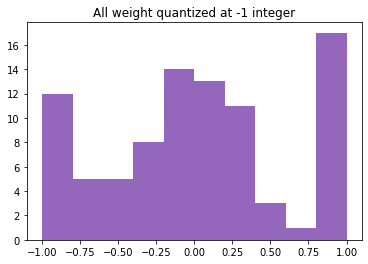

In [29]:
for i in range(bits_range):
    for v in range (1,4):
        k=1
        print(np.concatenate([i.flatten() for i in qmodel1.get_weights()]))
        plt.hist(np.concatenate([i.flatten() for i in qmodel1.get_weights()]))
        plt.title("All weight quantized at -1 integer")
plt.show()

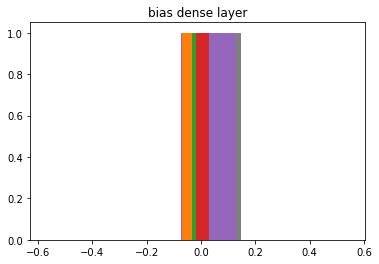

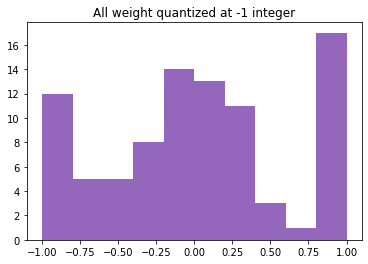

In [14]:
for i in range(bits_range):
    for v in range (1,4):
        k=1
        qmodel1 = qkeras.utils.load_qmodel(qmodels_path1(i,v,k))        
        plt.hist(np.concatenate([i.flatten() for i in qmodel1.layers[1].get_weights()[1]]))
        plt.title("bias dense layer")
plt.show()
for i in range(bits_range):
    for v in range (1,4):
        k=1
        plt.hist(np.concatenate([i.flatten() for i in qmodel1.get_weights()]))
        plt.title("All weight quantized at -1 integer")
plt.show()
        


In [15]:
for k in range(rest_units_range):
    loss1 = [] 
    loss2 = [] 
    loss3 = [] 
    yaxis = []
    sum1=0
    sum2=0
    sum3=0
    sum4=0
    sum5=0
    sum6=0
    sum0=0

    yaxis.append('<2,0>')
    yaxis.append('<4,0>')
    yaxis.append('<6,0>')
    yaxis.append('<8,0>')
    yaxis.append('<10,0>')
    yaxis.append('<12,0>')
    yaxis.append('<14,0>')
    for v in range (2):

        loss1 = [] 
        y_kerasref = np.load(predicts_path(0))
        y_keras0 = np.load(qpredicts_path0(0,v,k))
        y_keras1 = np.load(qpredicts_path0(1,v,k))
        y_keras2 = np.load(qpredicts_path0(2,v,k))
        y_keras3 = np.load(qpredicts_path0(3,v,k))
        y_keras4 = np.load(qpredicts_path0(4,v,k))
        y_keras5 = np.load(qpredicts_path0(5,v,k))
        y_keras6 = np.load(qpredicts_path0(6,v,k))
        y_keras0 = np.load(qpredicts_path0(0,v,k))
        y_keras1 = np.load(qpredicts_path0(1,v,k))
        y_keras2 = np.load(qpredicts_path0(2,v,k))
        y_keras3 = np.load(qpredicts_path0(3,v,k))
        y_keras4 = np.load(qpredicts_path0(4,v,k))
        y_keras5 = np.load(qpredicts_path0(5,v,k))
        y_keras6 = np.load(qpredicts_path0(6,v,k))

    
        sum0= sum0+mse(y_test,y_keras0)
        sum1= sum1+mse(y_test,y_keras1)
        sum2= sum2+mse(y_test,y_keras2)
        sum3= sum3+mse(y_test,y_keras3)
        sum4= sum4+mse(y_test,y_keras4)
        sum5= sum5+mse(y_test,y_keras5)
        sum6= sum6+mse(y_test,y_keras6)

        
        loss1.append(mse(y_test,y_keras0))   
        loss1.append(mse(y_test,y_keras1))
        loss1.append(mse(y_test,y_keras2))        
        loss1.append(mse(y_test,y_keras3))     
        loss1.append(mse(y_test,y_keras4))     
        loss1.append(mse(y_test,y_keras5))  
        loss1.append(mse(y_test,y_keras6)) 
        #
        #plt.plot(loss1,'+')
        print(loss1)

    loss2.append((sum0/versions_range))
    loss2.append((sum1/versions_range))
    loss2.append((sum2/versions_range))
    loss2.append((sum3/versions_range))
    loss2.append((sum4/versions_range))
    loss2.append((sum5/versions_range))
    loss2.append((sum6/versions_range))
    

    plt.yscale('log')
    plt.plot(loss2)
    #plt.legend(['bench 1','bench 2','bench 3','mean'])
plt.xticks(np.arange(len(yaxis)), [f"{Bit}" for Bit in yaxis])
plt.title(f'MSEs of qkeras models, initialized with pre-trained weights\n Comparison with different recurrent kernel quantization (x axis)')
plt.ylabel("MSE")
plt.xlabel("Bit width")

plt.axhline(mse(y_test, np.load(ref)), linestyle="--", color = 'red')
plt.legend(['rest set to <8,0>','rest set to <10,0>','rest set to <12,0>','ref'])


NameError: name 'qpredicts_path0' is not defined

[1.1511799e-05, 1.07185915e-05, 1.0604153e-05, 1.0475245e-05, 1.0264952e-05, 1.02083095e-05, 1.02988715e-05]
[1.4102619e-05, 1.0480782e-05, 1.0607156e-05, 1.03972825e-05, 1.0279293e-05, 1.0259076e-05, 1.02593485e-05]
[1.2110771e-05, 1.0697742e-05, 1.00218285e-05, 1.03695975e-05, 1.0297498e-05, 1.028709e-05, 1.0405542e-05]
[1.2015484e-05, 1.0575095e-05, 9.976513e-06, 1.0367382e-05, 1.0325598e-05, 1.050459e-05, 1.0278223e-05]
[1.2597519e-05, 1.0724586e-05, 1.0502817e-05, 9.753852e-06, 9.756654e-06, 9.8399205e-06, 1.0217298e-05]
[1.23692e-05, 1.0592816e-05, 1.0230003e-05, 9.894654e-06, 1.0006814e-05, 1.0210279e-05, 9.602004e-06]


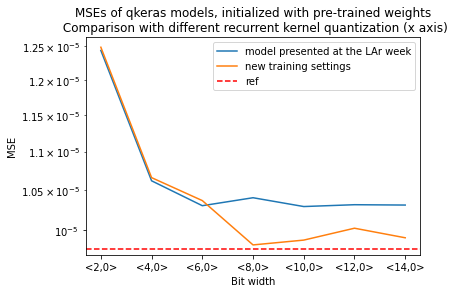

In [ ]:
yaxis = []
yaxis.append('<2,0>')
yaxis.append('<4,0>')
yaxis.append('<6,0>')
yaxis.append('<8,0>')
yaxis.append('<10,0>')
yaxis.append('<12,0>')
yaxis.append('<14,0>')


k=1
loss1 = [] 
loss2 = [] 
loss3 = [] 
best = []
worst = []

sum1=0
sum2=0
sum3=0
sum4=0
sum5=0
sum6=0
sum0=0


for v in range (versions_range):
    best[v]=100
    loss1 = [] 
    y_kerasref = np.load(predicts_path(0))
    y_keras0 = np.load(qpredicts_path0(0,v,k))
    y_keras1 = np.load(qpredicts_path0(1,v,k))
    y_keras2 = np.load(qpredicts_path0(2,v,k))
    y_keras3 = np.load(qpredicts_path0(3,v,k))
    y_keras4 = np.load(qpredicts_path0(4,v,k))
    y_keras5 = np.load(qpredicts_path0(5,v,k))
    y_keras6 = np.load(qpredicts_path0(6,v,k))



    sum0= sum0+mse(y_test,y_keras0)
    sum1= sum1+mse(y_test,y_keras1)
    sum2= sum2+mse(y_test,y_keras2)
    sum3= sum3+mse(y_test,y_keras3)
    sum4= sum4+mse(y_test,y_keras4)
    sum5= sum5+mse(y_test,y_keras5)
    sum6= sum6+mse(y_test,y_keras6)

    
    loss1.append(mse(y_test,y_keras0))   
    loss1.append(mse(y_test,y_keras1))
    loss1.append(mse(y_test,y_keras2))        
    loss1.append(mse(y_test,y_keras3))     
    loss1.append(mse(y_test,y_keras4))     
    loss1.append(mse(y_test,y_keras5))  
    loss1.append(mse(y_test,y_keras6)) 
    #
    #plt.plot(loss1,'+')
    print(loss1)

loss2.append((sum0/versions_range))
loss2.append((sum1/versions_range))
loss2.append((sum2/versions_range))
loss2.append((sum3/versions_range))
loss2.append((sum4/versions_range))
loss2.append((sum5/versions_range))
loss2.append((sum6/versions_range))

plt.plot(loss2)

loss1 = [] 
loss2 = [] 
loss3 = [] 
sum1=0
sum2=0
sum3=0
sum4=0
sum5=0
sum6=0
sum0=0


for v in range (2):

    loss1 = [] 
    y_kerasref = np.load(predicts_path(0))
    y_keras0 = np.load(qpredicts_path1(0,v,k))
    y_keras1 = np.load(qpredicts_path1(1,v,k))
    y_keras2 = np.load(qpredicts_path1(2,v,k))
    y_keras3 = np.load(qpredicts_path1(3,v,k))
    y_keras4 = np.load(qpredicts_path1(4,v,k))
    y_keras5 = np.load(qpredicts_path1(5,v,k))
    y_keras6 = np.load(qpredicts_path1(6,v,k))



    sum0= sum0+mse(y_test,y_keras0)
    sum1= sum1+mse(y_test,y_keras1)
    sum2= sum2+mse(y_test,y_keras2)
    sum3= sum3+mse(y_test,y_keras3)
    sum4= sum4+mse(y_test,y_keras4)
    sum5= sum5+mse(y_test,y_keras5)
    sum6= sum6+mse(y_test,y_keras6)

    
    loss1.append(mse(y_test,y_keras0))   
    loss1.append(mse(y_test,y_keras1))
    loss1.append(mse(y_test,y_keras2))        
    loss1.append(mse(y_test,y_keras3))     
    loss1.append(mse(y_test,y_keras4))     
    loss1.append(mse(y_test,y_keras5))  
    loss1.append(mse(y_test,y_keras6)) 
    #
    #plt.plot(loss1,'+')
    print(loss1)

loss2.append((sum0/2))
loss2.append((sum1/2))
loss2.append((sum2/2))
loss2.append((sum3/2))
loss2.append((sum4/2))
loss2.append((sum5/2))
loss2.append((sum6/2))

plt.plot(loss2)



plt.yscale('log')

#plt.legend(['bench 1','bench 2','bench 3','mean'])
plt.xticks(np.arange(len(yaxis)), [f"{Bit}" for Bit in yaxis])
plt.title(f'MSEs of qkeras models, initialized with pre-trained weights\n Comparison with different recurrent kernel quantization (x axis)')
plt.ylabel("MSE")
plt.xlabel("Bit width")

plt.axhline(mse(y_test, np.load(ref)), linestyle="--", color = 'red')
plt.legend(['model presented at the LAr week','new training settings','ref'])


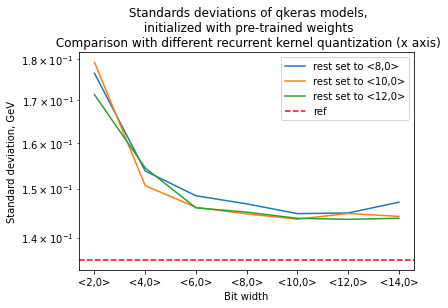

In [ ]:
yaxis=[]
yaxis.append('<2,0>')
yaxis.append('<4,0>')
yaxis.append('<6,0>')
yaxis.append('<8,0>')
yaxis.append('<10,0>')
yaxis.append('<12,0>')
yaxis.append('<14,0>')

cut_indices = np.where(y_test > 0.24/16)[0]
preds = np.load(std_ref)
cut_y = y_test[cut_indices]
reso = preds - cut_y
ref_stdev = np.std(reso*16)

for k in range (rest_units_range):
    std=[]
    for i in range(bits_range):
        stdev_mean=0
        for v in range (versions_range):
            cut_indices = np.where(y_test > 0.24/16)[0]
            preds = np.load(qpredicts_path1(i,v,k))
            cut_y = y_test[cut_indices]
            reso = preds - cut_y
            stdev = np.std(reso*16)
            stdev_mean=stdev_mean+stdev
        std.append(stdev_mean/versions_range)
    plt.plot(std)
#plt.axhline(mse(y_test, np.load(ref)), linestyle="--", color = 'red')
plt.axhline(ref_stdev, linestyle="--", color = 'red')
plt.legend(['rest set to <8,0>','rest set to <10,0>','rest set to <12,0>','ref'])
plt.title(f' Standards deviations of qkeras models,\n initialized with pre-trained weights\n Comparison with different recurrent kernel quantization (x axis)')
plt.ylabel("Standard deviation, GeV")
plt.xlabel("Bit width")
plt.xticks(np.arange(len(yaxis)), [f"{Bit}" for Bit in yaxis])
plt.yscale('log')
plt.show()

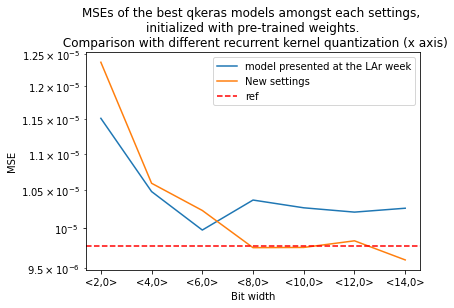

In [ ]:
yaxis=[]
yaxis.append('<2,0>')
yaxis.append('<4,0>')
yaxis.append('<6,0>')
yaxis.append('<8,0>')
yaxis.append('<10,0>')
yaxis.append('<12,0>')
yaxis.append('<14,0>')
k=1
loss=[]
for i in range(bits_range):
    best_mse=100
    for v in range (versions_range):
        y_keras0 = np.load(qpredicts_path0(i,v,k))
        tmp_mse = mse(y_test,y_keras0)
        if (best_mse>tmp_mse): best_mse=tmp_mse
    loss.append(best_mse)
plt.plot(loss)
loss=[]
for i in range(bits_range):
    best_mse=100
    for v in range (2):
        y_keras0 = np.load(qpredicts_path1(i,v,k))
        tmp_mse = mse(y_test,y_keras0)
        if (best_mse>tmp_mse): best_mse=tmp_mse
    loss.append(best_mse)
plt.plot(loss)

#plt.axhline(MSETIENNE, linestyle="-", color = 'blue')
plt.axhline(mse(y_test, np.load(ref)), linestyle="--", color = 'red')
plt.legend(['model presented at the LAr week','new training settings','ref'])
plt.title(f'MSEs of the best qkeras models amongst each settings, \ninitialized with pre-trained weights.\n Comparison with different recurrent kernel quantization (x axis)')
plt.ylabel("MSE")
plt.xlabel("Bit width")
plt.xticks(np.arange(len(yaxis)), [f"{Bit}" for Bit in yaxis])
plt.yscale('log')
plt.show()

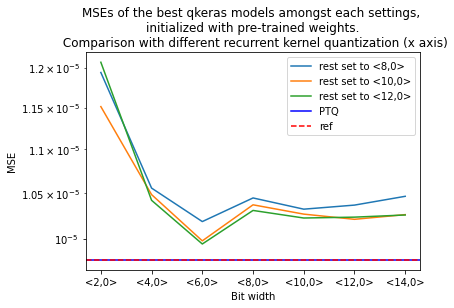

In [ ]:
yaxis=[]
yaxis.append('<2,0>')
yaxis.append('<4,0>')
yaxis.append('<6,0>')
yaxis.append('<8,0>')
yaxis.append('<10,0>')
yaxis.append('<12,0>')
yaxis.append('<14,0>')

for k in range (rest_units_range):
    loss=[]
    for i in range(bits_range):
        best_mse=100
        for v in range (versions_range):
            y_keras0 = np.load(qpredicts_path0(i,v,k))
            tmp_mse = mse(y_test,y_keras0)
            if (best_mse>tmp_mse): best_mse=tmp_mse
        loss.append(best_mse)
    plt.plot(loss)
plt.axhline(MSETIENNE, linestyle="-", color = 'blue')
plt.axhline(mse(y_test, np.load(ref)), linestyle="--", color = 'red')
plt.legend(['rest set to <8,0>','rest set to <10,0>','rest set to <12,0>','PTQ','ref'])
plt.title(f'MSEs of the best qkeras models amongst each settings, \ninitialized with pre-trained weights.\n Comparison with different recurrent kernel quantization (x axis)')
plt.ylabel("MSE")
plt.xlabel("Bit width")
plt.xticks(np.arange(len(yaxis)), [f"{Bit}" for Bit in yaxis])
plt.yscale('log')
plt.show()

In [ ]:
y_keras0 = np.loadtxt("../out-c1.txt")
print(y_keras0.shape)
y_test = y_test[4:]
print(y_test.shape)
tmp_mse = mse(y_test,y_keras0)

(999994,)
(999994, 1)


In [ ]:
print(tmp_mse)

0.001678256826182726
